# Implied Volatility vs Historical Volatility

<b> YouTube Tutorial </b> (Published:
Nov 21, 2022): https://youtu.be/ZrXM0KizUsM

In today's tutorial we investigate how you can use ThetaData's API to retreive 10 years of historical options data for comparing Implied Volatility to Historical Volatility.

## Q: What is the difference between Actual and Implied Volatility?

### Historical/Actual/Realized Volatility (rv)

Realized volatility (rv) is the actual stock price variability due to randomness of the underlying Brownian motion the stock price. Using the stock return model (the solution of Geometric Brownian Motion SDE), the realized volatility is the coefficient of the Browanian Motion process (Wiener process). We will explain this more using some ito calculus in the next video!

Stock Returns Model

$\large ln \frac{S_t}{S_0} = (\mu - \frac{\sigma^2}{2})t + \sigma^\mathbb{P} W_t$

$\large r_t = ln \frac{S_t}{S_0}$

Realized Volatility (over the entire period of time)

$\large rv^{(N)}_t = \sigma^\mathbb{P} \approx \sqrt{\sum^{N} {r_t}^2}$

Realized Volatility (for each period of time - unbiased std dev.)

$\large rv_t = \sigma^\mathbb{P} \approx \sqrt{\sum^{N} \frac{{r_t}^2}{N-1}}$

Difference between realized volatility as the sqaure root of sum of squared returns or standard deviation of [returns](https://quant.stackexchange.com/questions/19317/realized-volatility-vs-standard-deviation-of-log-returns)?  The only difference is frequency. You would think you should use average log return over period. Look  at papers Andersen, Bollerslev, Diebold and Labys 2001 and Barndorff-Nielsen and
Shephard 2001, 2002. Refer to this [link](https://people.unipi.it/fulvio_corsi/wp-content/uploads/sites/473/2018/08/FulvioCorsi_Tesi_2005.pdf)

### Implied Volatility (iv)

Implied volatility is how the market is pricing the option currently. To calculate implied volatility you use the market price of the option (as well as the contract terms) and a theoretical pricing model depending on the type of option being priced. For example using the Black-Scholes model, we get the price of a European call option is given by:

$\large C = S_t \Phi{(d_1)} - Ke^{-r\tau} \Phi{(d_2)}$

where:

$\large d_1 = \frac{ln\frac{S_t}{K} + (r + \frac{\sigma^2}{2}\tau)}{\sigma \sqrt{\tau}}$ and

$\large d_2 = d_1 - \sigma \sqrt{\tau}$

- $\large S_t$ todays stock price
- $\large K$ strike price of option
- $\large \sigma$ volatility
- $\large r$ interest rate
- $\large \tau = T - t$


Difference between Maturity time T and todays date t

The implied volatility is the volatility that results in the observed market price of the option.
For a particular option with strike $\large K$, and time to expiry $\large \tau$, there will be an observable market price.

$\large C_{obs}(K, \tau) = C(\sigma^{\mathbb{Q}}, K, \tau)$

This can be obtained by a root finding methods like Newton, bi-section, secant or brent method. Specifically for the case of Black-Scholes model, there is also a more rational way to compute implied volatility and we will explore this in our series.

## Realized vs Implied Volatility

Since the market does not have perfect knowledge about the future these two numbers can and will be different.

Therein, lies the risk management problem / business or trading opportunity.

In [ ]:
!pip install thetadata

In [ ]:
import os
import time
import pickle

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import timedelta, datetime, date
from thetadata import ThetaClient, OptionReqType, OptionRight, DateRange, DataType, StockReqType

## Get all Expirations for MSFT Options

First thing we need is all the expiry dates of all contracts on MSFT that ThetaData has available.

In [ ]:
your_username = ''
your_password = ''

def get_expirations(root_ticker) -> pd.DataFrame:
    """Request expirations from a particular options root"""
    # Create a ThetaClient
    client = ThetaClient(username=your_username, passwd=your_password, jvm_mem=4, timeout=15)

    # Connect to the Terminal
    with client.connect():

        # Make the request
        data = client.get_expirations(
            root=root_ticker,
        )

    return data

### Making requests to API for all Contracts by Expiry Dates

In [ ]:
root_ticker = 'MSFT'
expirations = get_expirations(root_ticker)
expirations

## Get all Strikes for each MSFT Option Expiry

We will need these later, so I will build up a dictionary and pickle this data for future use.

In [ ]:
def get_strikes(root_ticker, expiration_dates) -> pd.DataFrame:
    """Request strikes from a particular option contract"""
    # Create a ThetaClient
    client = ThetaClient(username=your_username, passwd=your_password, jvm_mem=4, timeout=15)

    all_strikes = {}

    # Connect to the Terminal
    with client.connect():

        for exp_date in expiration_dates:

            # Make the request
            data = client.get_strikes(
                root=root_ticker,
                exp=exp_date
            )

            all_strikes[exp_date] = pd.to_numeric(data)


    return all_strikes

### Making requests to API for Strikes

In [ ]:
root_ticker = 'MSFT'

all_strikes = get_strikes(root_ticker, expirations)

with open('MSFT_strikes.pkl', 'wb') as f:
    pickle.dump(all_strikes, f)

In [ ]:
with open('MSFT_strikes.pkl', 'rb') as f:
    all_strikes = pickle.load(f)

all_strikes[expirations[360]]

0      80.0
1      85.0
2      90.0
3      95.0
4      99.0
5      99.5
6     100.0
7     101.0
8     102.0
9     103.0
10    104.0
11    105.0
12    106.0
13    107.0
14    108.0
15    109.0
16    110.0
17    111.0
18    112.0
19    113.0
20    114.0
21    115.0
22    116.0
23    117.0
24    118.0
25    119.0
26    120.0
27    121.0
28    122.0
29    123.0
30    124.0
31    125.0
32    126.0
33    127.0
34    128.0
35    129.0
36    130.0
37    131.0
38    132.0
39    133.0
40    134.0
41    135.0
42    136.0
43    137.0
44    138.0
45    139.0
46    140.0
dtype: float64

## MSFT Underlying ThetaData Request

We will be leveraging the ability to aggregate time periods throughout the day using the API, by defining a interval_size. We will then compare the historical volatility to the implied volatility for every trading day for quotes that were made in the underlying and options of ATM options in the afternoon (14:00).

In [ ]:
def get_hist_stock(root_ticker, trading_days, interval_size) -> pd.DataFrame:
    """Request historical data for an underlying"""
    # Create a ThetaClient
    client = ThetaClient(username=your_username, passwd=your_password, jvm_mem=4, timeout=15)

    underlying = {}

    # Connect to the Terminal
    with client.connect():
        # Make the request

        for tdate in trading_days:

            try:
                data = client.get_hist_stock(
                    req=StockReqType.QUOTE,
                    root=root_ticker,
                    date_range=DateRange(tdate, tdate),
                    interval_size=interval_size
                )

                data = data.apply(weighted_mid_price, axis=1)

                underlying[tdate] = data[4]

            except:
                underlying[tdate] = np.nan

    return underlying

### Calculate Weighted Mid Price (Micro-Price)

Calculate the weighted mid price (micro-price) for each row within our quotes dataframe.

In [ ]:
def weighted_mid_price(row):
    try:
        V_mid = row[DataType.ASK_SIZE] + row[DataType.BID_SIZE]
        x_a = row[DataType.ASK_SIZE]/V_mid
        x_b = 1 - x_a
        return row[DataType.ASK]*x_a + row[DataType.BID]*x_b
    except:
        return np.nan

### Making requests to API for Underlying

In [ ]:
root_ticker = 'MSFT'
trading_days = pd.date_range(start=datetime(2012,6,1),end=datetime(2022,11,14),freq='B')
interval_size = 60*60000

underlying = get_hist_stock(root_ticker, trading_days, interval_size)

with open('underlying.pkl', 'wb') as f:
    pickle.dump(underlying, f)

## Volatility over 30d window (~21 trading days)

Now I want to compute the [realized volatility over a number of days](https://people.unipi.it/fulvio_corsi/wp-content/uploads/sites/473/2018/08/FulvioCorsi_Tesi_2005.pdf), and we can calculate this by applying the standard deviation over a rolling window. H=30d but this is equivalent to approximately 21 trading days (or points of data).

$\large rv^{H}_t \approx \sqrt{\sum^{M-1}_{j=0} {r^2_{t-j\Delta}}}$

where:
- $\large \Delta = \frac{H}{M}$ and
- $\large r_{t-j\Delta} = ln \frac{S_{t-j\Delta}}{S_{t-(j+1)\Delta}}$

In [ ]:
with open('underlying.pkl', 'rb') as f:
    underlying = pickle.load(f)

spot = pd.DataFrame(underlying.items(), columns=['trade_date', 'price'])
spot.set_index('trade_date', inplace=True)
spot = spot.dropna()

log_returns = np.log(spot/spot.shift(1)).dropna()

TRADING_DAYS = 21
spot['vol'] = log_returns.rolling(window=TRADING_DAYS).std()*np.sqrt(252)
spot.tail()

,price,vol
trade_date,,
2022-11-08,227.345000,0.420429
2022-11-09,225.233333,0.420874
2022-11-10,239.585000,0.471681
2022-11-11,247.550000,0.468133
2022-11-14,243.555000,0.467186


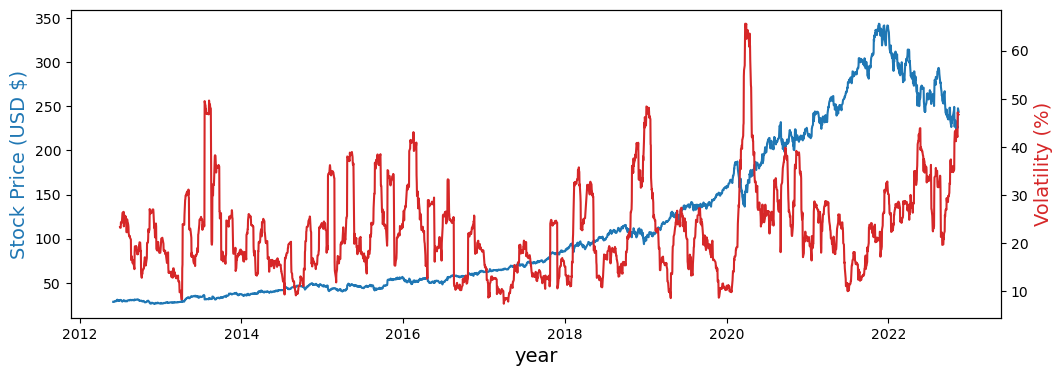

In [ ]:
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(spot['price'], color='tab:blue')
ax2=ax.twinx()
ax2.plot(spot['vol']*100, color='tab:red')

# set x-axis label
ax.set_xlabel("year", fontsize = 14)
# set y-axis label
ax.set_ylabel("Stock Price (USD $)",
              color="tab:blue",
              fontsize=14)

ax2.set_ylabel("Volatility (%)",color="tab:red",fontsize=14)
plt.show()

## Market-Makers are not forced to show Quotes on all options!

There are rules listed for each Exchange that market makers must abide by. For Example on the NASDAQ where MSFT trades here are the [rules](https://listingcenter.nasdaq.com/rulebook/mrx/rules)

Specifically there is a large difference between the obligation of a Competitive Market Maker and the Primary Market Makers for a particular options series. This is notable in whether they need to present two-sided quotes on Non-standard options like weekly or quarterly expiry options and adjusted options.

To be safe here, we will only want to return option contracts with 'standard' option expires. These expire on the Saturday following the third Friday of the month, and some have the expiry date as the Third friday of the month, but in the past were recorded as the Saturday. Therefore we need to find the intersection of all the expiries that Thetadata has options data for and the 3rd Fridays and the following Saturday dates for every month since Jun-2021.

In [ ]:
trading_days = pd.date_range(start=datetime(2012,6,1),end=datetime(2022,11,14),freq='B')
# The third friday in every month
contracts1 = pd.date_range(start=datetime(2012,6,1),end=datetime(2024,12,31),freq='WOM-3FRI')
# Saturday following the third friday in every month
contracts2 = pd.date_range(start=datetime(2012,6,1),end=datetime(2022,12,31),freq='WOM-3FRI')+timedelta(days=1)
# Combine these contracts into a total pandas index list
contracts = contracts1.append(contracts2)
# Find contract expiries that match with ThetaData expiries
mth_expirations = [exp for exp in expirations if exp in contracts]
# Convert from python list to pandas datetime
mth_expirations = pd.to_datetime(pd.Series(mth_expirations))

print('Number of possible monthly contracts', len(contracts), 'compared to total avail',len(mth_expirations),
      'compared to total no. options avail (incl. quarterly + weekly)', len(expirations))

Number of possible monthly contracts 278 compared to total avail 134 compared to total no. options avail (incl. quarterly + weekly) 563


## Days to Expiry (DTE)

Find the contracts that are closest 1mth, 2mth, 3mth and 4mth to expiry

In [ ]:
trading_days = pd.date_range(start=datetime(2012,6,1),end=datetime(2022,11,14),freq='B')

contracts = {}
DTE = [30,60,90,120]
for trade_date in trading_days:
    days = [delta.days for delta in mth_expirations - trade_date]
    index_contracts = [min({(abs(day-dte),i) for i,day in enumerate(days)})[1] for dte in DTE]
    contracts[trade_date] = index_contracts

In [ ]:
contracts[datetime(2012,6,1)], contracts[datetime(2021,6,1)]

([0, 1, 2, 3], [107, 108, 109, 110])

## Implied volatility requests

ThetaData uses the quotes information on a particular options chain for a specific trading day to compute the implied volatility. For every trading day we will look forward to the closest monthly trading option contracts and get the closest strike to the underlying (~ATM), and retrieve the implied volatility for the contracts ~30d (1mth), ~60d (2mth), ~90d (3mth) and ~120d (4mth) to expiry.  

In [ ]:
# Make the request
def implied_vol(root_ticker, trading_days, interval_size=0, opt_type=OptionRight.CALL) -> pd.DataFrame:
    """Request quotes both bid/ask options data"""
    # Create a ThetaClient
    client = ThetaClient(username=your_username, passwd=your_password, jvm_mem=4, timeout=15)

    # Store all iv in datas dictionary
    datas = {}
    DTE = ['1mth','2mth','3mth','4mth']
    total_days = len(trading_days)

    # Connect to the Terminal
    with client.connect():

        for ind, trade_date in enumerate(trading_days):

            print('*'*100, '\nSTART:' ,trade_date, ind+1, '/', total_days ,'\n','*'*100)

            # Get the expiry dates for specific contracts on particular trade date
            exp_dates = mth_expirations[contracts[trade_date]]
            datas[trade_date] = {}

            # For each expiry we want to get closest ATM iv
            for exp_ind, exp_date in enumerate(exp_dates):

                # determine closest ATM strike - iterate through all strikes of expiry date.
                diff_strike = [delta for delta in all_strikes[exp_date] - underlying[trade_date]]
                # Min. difference between particular DTE interested, return index
                index_strike = min({(abs(Kdiff),i) for i,Kdiff in enumerate(diff_strike)})[1]
                # Return closest ATM strike
                strike = all_strikes[exp_date][index_strike]

                try:
                    # Attempt to request historical options implied volatility
                    data = client.get_hist_option(
                        req=OptionReqType.IMPLIED_VOLATILITY,
                        root=root_ticker,
                        exp=exp_date,
                        strike=strike,
                        right=opt_type,
                        date_range=DateRange(trade_date, trade_date),
                        progress_bar=False,
                        interval_size=interval_size
                    )

                    # Store data in dictionary
                    datas[trade_date][DTE[exp_ind]] = data.loc[4,DataType.IMPLIED_VOL]

                except:
                    # If unavailable, store np.nan
                    datas[trade_date][DTE[exp_ind]] =  np.nan

    return datas

### Making requests to API for IV

In [ ]:
start_all = time.time()

datas_call = implied_vol(root_ticker, trading_days, interval_size = 60*60000, opt_type=OptionRight.CALL)

with open('datas_mth_calls.pkl', 'wb') as f:
    pickle.dump(datas_call, f)

datas_put = implied_vol(root_ticker, trading_days, interval_size = 60*60000, opt_type=OptionRight.PUT)

with open('datas_mth_puts.pkl', 'wb') as f:
    pickle.dump(datas_put, f)

end_all = time.time()
print('*'*100,'  TOTAL time taken {:.2f} s'.format(end_all-start_all),'*'*100)

### To demonstrate what that looks like

In [ ]:
trading_days = pd.date_range(start=datetime(2022,11,7),end=datetime(2022,11,11),freq='B')

start_all = time.time()

datas = implied_vol(root_ticker, trading_days, interval_size = 60*60000, opt_type=OptionRight.CALL)

end_all = time.time()
print('*'*100,'  TOTAL time taken {:.2f} s'.format(end_all-start_all),'*'*100)

df = pd.DataFrame(datas.items(), columns=['trade_date', 'price'])
N = len(df)
calls = np.empty([N, 4])
for ind, (date, data) in enumerate(datas.items()):
    calls[ind, 0] = data['1mth']
    calls[ind, 1] = data['2mth']
    calls[ind, 2] = data['3mth']
    calls[ind, 3] = data['4mth']

df = pd.DataFrame(data=calls, index=df.trade_date, columns=['1mth','2mth','3mth','4mth'])
df

Starting Theta Terminal version 0.5.9 REV: A
CONFIG DIR: C:\Users\Jonathon Emerick\ThetaData\ThetaTerminal
**************************************************************************************************** 
START: 2022-11-07 00:00:00 1 / 5 
 ****************************************************************************************************
Unable to connect to: nj-a.thetadata.us:12000 attempting to connect to another server...
Attempting login as pythonforquants@gmail.com
CONNECTED to: nj-a.thetadata.us:12001, Account Type: PRO, Data Permission: Real-Time
API connected: Socket[addr=/127.0.0.1,port=62565,localport=11000]
REQ: MSG_CODE=200&version=0.5.6
REQ: MSG_CODE=200&START_DATE=20221107&END_DATE=20221107&root=MSFT&exp=20221216&strike=225000&right=C&sec=OPTION&req=202&rth=True&IVL=3600000
REQ: MSG_CODE=200&START_DATE=20221107&END_DATE=20221107&root=MSFT&exp=20230120&strike=225000&right=C&sec=OPTION&req=202&rth=True&IVL=3600000
REQ: MSG_CODE=200&START_DATE=20221107&END_DATE=20221107

,1mth,2mth,3mth,4mth
trade_date,,,,
2022-11-07,0.3187,0.3153,0.3356,0.3342
2022-11-08,0.3236,0.3230,0.3384,0.3326
2022-11-09,0.3299,0.3264,0.3444,0.3398
2022-11-10,0.2986,0.3015,0.3238,0.3214
2022-11-11,0.2891,0.2917,0.3132,0.3131


## Visualise IV from Calls

In [ ]:
with open('datas_mth_calls.pkl', 'rb') as f:
    datas_call = pickle.load(f)

df_calls = pd.DataFrame(datas_call.items(), columns=['trade_date', 'price'])

N = len(datas_call)
calls = np.empty([N, 4])
for ind, (date, data) in enumerate(datas_call.items()):
    calls[ind, 0] = data['1mth']
    calls[ind, 1] = data['2mth']
    calls[ind, 2] = data['3mth']
    calls[ind, 3] = data['4mth']

df_calls = pd.DataFrame(data=calls, index=df_calls.trade_date, columns=['1mth','2mth','3mth','4mth'])
print('Data available', len(df_calls.dropna(how='all')), 'out of', len(df_calls))

df_calls = df_calls.dropna(how='all')
df_calls

Data available 1850 out of 2727


,1mth,2mth,3mth,4mth
trade_date,,,,
2012-06-01,0.2447,0.2546,0.2505,NaN
2012-06-04,0.2756,0.2756,0.2620,NaN
2012-06-05,0.2459,0.2459,0.2331,NaN
2012-06-06,0.2369,0.2274,0.2274,0.2202
2012-06-07,0.2282,0.2236,NaN,NaN
...,...,...,...,...
2022-11-08,0.3236,0.3230,0.3384,0.3326
2022-11-09,0.3299,0.3264,0.3444,0.3398
2022-11-10,0.2986,0.3015,0.3238,0.3214


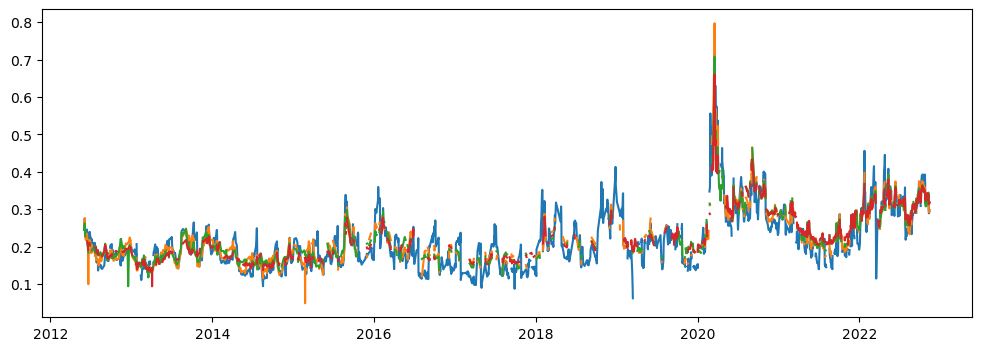

In [ ]:
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(df_calls['1mth'])
ax.plot(df_calls['2mth'])
ax.plot(df_calls['3mth'])
ax.plot(df_calls['4mth'])
plt.show()

## Whats happening to 1mth+ options series?

Why does it appear there were no quotations on some options (ATM options I remind you), prior to 2020?

I encourage you to read the NASDAQ exchange [rules](https://listingcenter.nasdaq.com/rulebook/mrx/rules) and you will notice in Section 5. Market Maker Quotations, this was Adopted Dec 6, 2019 and ammended a few times since then.

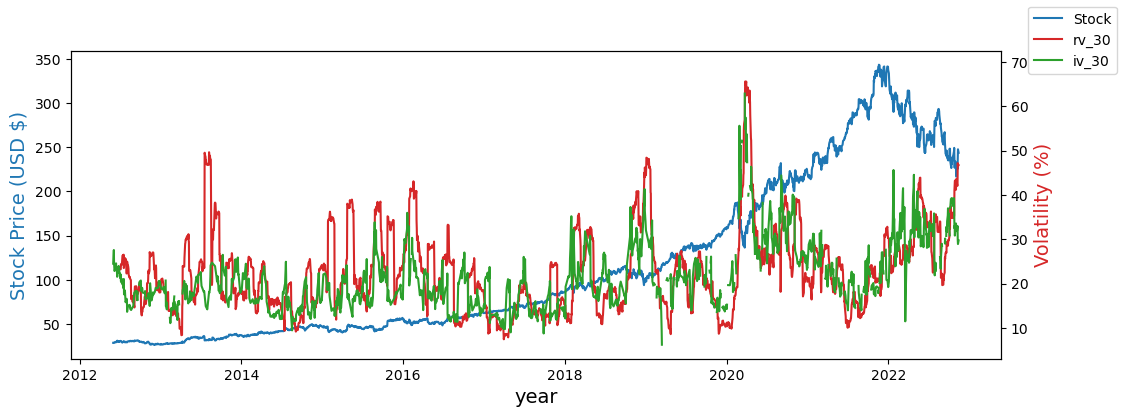

In [ ]:
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(spot['price'], color='tab:blue', label='Stock')
ax2=ax.twinx()
ax2.plot(spot['vol']*100, color='tab:red', label='rv_30')
ax2.plot(df_calls['1mth']*100, color='tab:green', label='iv_30')
# set x-axis label
ax.set_xlabel("year", fontsize = 14)
# set y-axis label
ax.set_ylabel("Stock Price (USD $)",
              color="tab:blue",
              fontsize=14)

ax2.set_ylabel("Volatility (%)",color="tab:red",fontsize=14)

fig.legend()
plt.show()

## Is this a fair comparison?

Let's consider time scales:
1. Realized Volatility (rv) is backwards looking over H time periods. $\large rv(t - H \rightarrow t)$
2. Implied Volatility (iv) is forwards looking over H time periods. $\large iv(t \rightarrow t+H)$

So to compare these visually we could shift rv backwards by the period H so that we can compare $\large rv_{t-H}(t \rightarrow t+H)$ to $\large iv(t \rightarrow t+H)$

In [ ]:
spot['vol_shift'] = spot['vol'].shift(-21)
spot

,price,vol,vol_shift
trade_date,,,
2012-06-01,28.553448,NaN,0.233152
2012-06-04,28.404813,NaN,0.231876
2012-06-05,28.530000,NaN,0.232124
2012-06-06,29.016635,NaN,0.243304
2012-06-07,29.316115,NaN,0.241507
...,...,...,...
2022-11-08,227.345000,0.420429,NaN
2022-11-09,225.233333,0.420874,NaN
2022-11-10,239.585000,0.471681,NaN


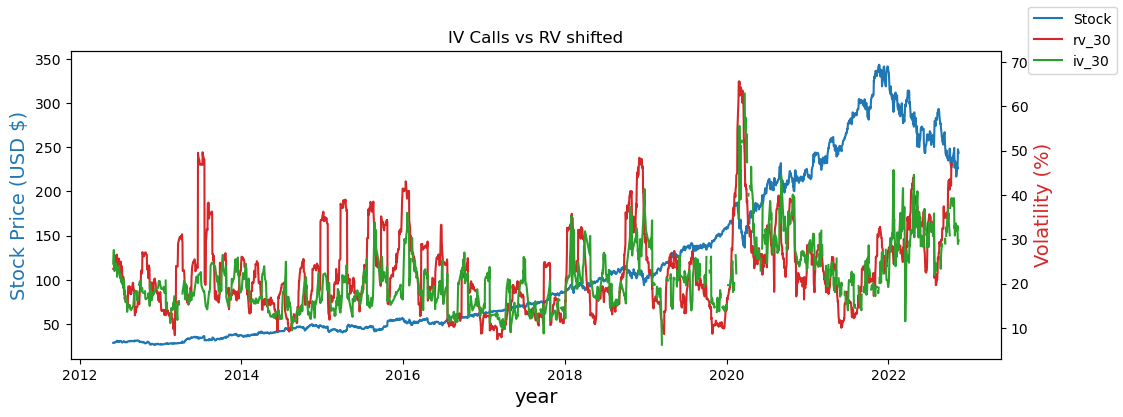

In [ ]:
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(spot['price'], color='tab:blue', label='Stock')
ax2=ax.twinx()
plt.title('IV Calls vs RV shifted')
ax2.plot(spot['vol_shift']*100, color='tab:red', label='rv_30')
ax2.plot(df_calls['1mth']*100, color='tab:green', label='iv_30')
# set x-axis label
ax.set_xlabel("year", fontsize = 14)
# set y-axis label
ax.set_ylabel("Stock Price (USD $)",
              color="tab:blue",
              fontsize=14)

ax2.set_ylabel("Volatility (%)",color="tab:red",fontsize=14)

fig.legend()
plt.show()

In [ ]:
with open('datas_mth_puts.pkl', 'rb') as f:
    datas_put = pickle.load(f)

df_puts = pd.DataFrame(datas_put.items(), columns=['trade_date', 'price'])

N = len(datas_put)
puts = np.empty([N, 4])
for ind, (date, data) in enumerate(datas_put.items()):
    puts[ind, 0] = data['1mth']
    puts[ind, 1] = data['2mth']
    puts[ind, 2] = data['3mth']
    puts[ind, 3] = data['4mth']
# df.set_index('trade_date', inplace=True)
# df = df.dropna()

df_puts = pd.DataFrame(data=puts, index=df_puts.trade_date, columns=['1mth','2mth','3mth','4mth'])
print('Data available', len(df_puts.dropna(how='all')), 'out of', len(df_puts))

df_puts = df_puts.dropna(how='all')
df_puts

Data available 1850 out of 2727


,1mth,2mth,3mth,4mth
trade_date,,,,
2012-06-01,0.2546,0.2838,0.2917,NaN
2012-06-04,0.2982,0.2982,0.3153,NaN
2012-06-05,0.2722,0.2722,0.2906,NaN
2012-06-06,0.2530,0.2829,0.2829,0.2857
2012-06-07,0.2536,0.2765,NaN,NaN
...,...,...,...,...
2022-11-08,0.3363,0.3235,0.3429,0.3377
2022-11-09,0.3473,0.3314,0.3496,0.3444
2022-11-10,0.3154,0.3051,0.3268,0.3243


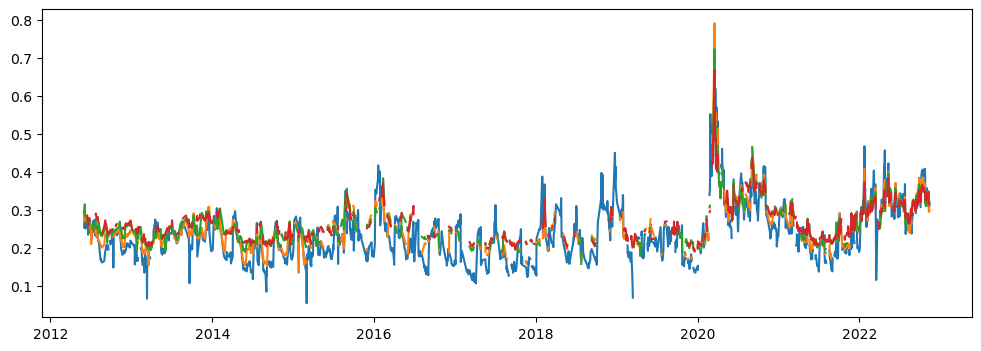

In [ ]:
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(df_puts['1mth'])
ax.plot(df_puts['2mth'])
ax.plot(df_puts['3mth'])
ax.plot(df_puts['4mth'])
plt.show()

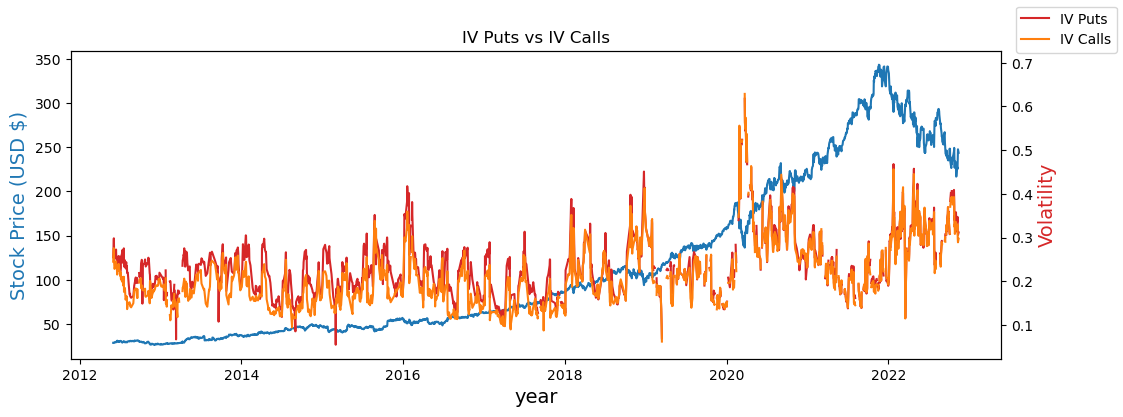

In [ ]:
fig,ax = plt.subplots(figsize=(12,4))
ax.plot(spot['price'], color='tab:blue')
ax2=ax.twinx()
plt.title('IV Puts vs IV Calls')
ax2.plot(df_puts['1mth'], color='tab:red', label='IV Puts')
ax2.plot(df_calls['1mth'], color='tab:orange', label='IV Calls')
# set x-axis label
ax.set_xlabel("year", fontsize = 14)
# set y-axis label
ax.set_ylabel("Stock Price (USD $)",
              color="tab:blue",
              fontsize=14)

ax2.set_ylabel("Volatility",color="tab:red",fontsize=14)
fig.legend()
plt.show()